<a href="https://colab.research.google.com/github/fangyiyu/Honeyword_GPT3/blob/main/HGT_targeted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing and Installing

In [ ]:
!pip install openai
!pip install ckl-psm
!pip install fasttext
!pip install zxcvbn-python
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer, util

In [8]:
import os
import torch
import openai
import random 
import fasttext
import numpy as np
import pandas as pd
import seaborn as sns
from zxcvbn import zxcvbn
from ckl_psm import ckl_pcfg as psm
dataset = sns.load_dataset('penguins')
openai.api_key = "INSERT YOUR OPENAI KEY HERE"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/UOIT/'Research '/GPT-3/

/content/drive/MyDrive/UOIT/Research /GPT-3


In [4]:
NUM_SWEETWORDS = 20 
NUM_USER = 1000
NUM_ATTEMPT = 20 

In [9]:
# calculate cosine similarity between two strings with MPNet embedding
model = SentenceTransformer("nli-mpnet-base-v2")
def cal_similarity(pw1, pw2):
    pw1_embedding = model.encode(pw1, convert_to_tensor=True)
    pw2_embedding = model.encode(pw2, convert_to_tensor=True)
    relevance = util.pytorch_cos_sim(pw1_embedding, pw2_embedding)[0]
    score = relevance.item()
    return score

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/587 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [10]:
def avg_scores(scores):
  avg_scores = [0 for x in range(NUM_USER)]
  for i in range(NUM_USER):
    avg_score = sum(scores[i][1:])/len(scores[i][1:])
    avg_scores[i] = avg_score
  return avg_scores

In [13]:
ps_emails = pd.read_csv("data/ps_emails.csv")

In [14]:
ps_emails.tail(10)

,username,email,pass,service,date,score
249996,w7oodi_114,hotmail.com,japalami,Collection1,1/7/2019,2
249997,x4getmenot91x,hotmail.com,ix3gina,MySpace,7/1/2008,1
249998,x4hyclqvfc,nospamfor.us,RMMFhMuP,Lastfm,3/22/2012,2
249999,yahaira_bautista11,hotmail.com,yahis07,MySpace,7/1/2008,2
250000,yahaira_criz14,hotmail.com,pekere12,MySpace,7/1/2008,2
250001,yahaira_danny,hotmail.com,yahaira1a,MySpace,7/1/2008,1
250002,yahaira_lizbeth_93,hotmail.com,yahaira-,MySpace,7/1/2008,1
250003,yahalink,mail.ru,240773YL,VK,1/1/2012,2
250004,yahali_zena786523,yahoo.com,tonysalah5,MySpace,7/1/2008,3
250005,z9101999,mail.ru,Дисант,VK,1/1/2012,1


In [15]:
len(ps_emails)

250006

## Password Selection
Selecting passwords based on two rules:
1. Length in range of 12 to 32.
2. The 1000 strongest passwords and the 1000 weakest passwords based on zxcvbn.

In [16]:
ps_emails.isnull().values.sum()

0

In [18]:
# only keep the passwords with length in range of 12 and 32
mask = (ps_emails['pass'].str.len() > 12) &(ps_emails['pass'].str.len() < 32)
ps_emails_long = ps_emails.loc[mask]

In [19]:
len(ps_emails_long)

28492

In [20]:
ps_emails_long.groupby(['service']).size().describe()

count       80.000000
mean       356.150000
std       1368.719415
min          1.000000
25%          1.000000
50%          3.000000
75%         19.000000
max      10168.000000
dtype: float64

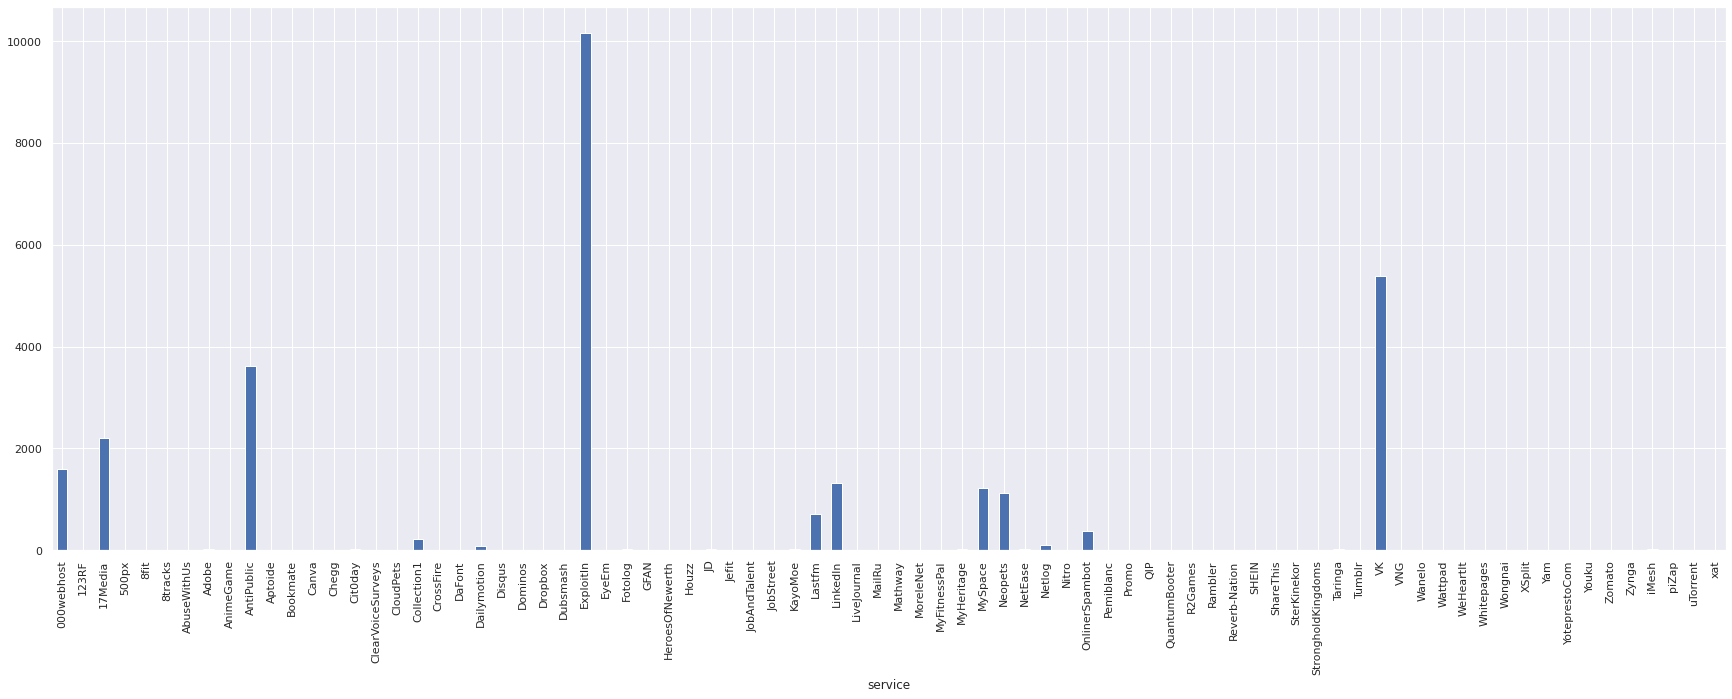

In [21]:
sns.set(rc={'figure.figsize':(30, 10)})
ps_emails_long.groupby(['service']).size().plot(kind = "bar")

In [22]:
ps_emails_long.groupby(['service']).size().sort_values(ascending=False).head(10)

service
ExploitIn         10168
VK                 5384
AntiPublic         3628
17Media            2201
000webhost         1597
LinkedIn           1315
MySpace            1231
Neopets            1116
Lastfm              715
OnlinerSpambot      376
dtype: int64

In [23]:
ps_emails_long = ps_emails_long.rename(columns={"pass": "pw"})

In [59]:
ps_emails_new = ps_emails_long[['username', 'pw']]

In [60]:
len(ps_emails_new)

28492

In [93]:
# caculate password strength using zxcvbn for each password
strength = []
for row in ps_emails_new.itertuples():
  strength.append(zxcvbn(row.pw)['score'])
ps_emails_new['strength'] = strength

In [96]:
ps_emails_new

,username,pw,strength
0,00-00-00-00,данияр123456789101112131415,4
2,10--camii--07,100797patitas25,4
3,20--w484-korchak_valja,rjhxfr321ledivivi,4
10,40-1-bol-teste-testando,"397,626,962,188,124",4
11,40-1-letra_b-teste-testando,"546,892,118,735,621",4
...,...,...,...
249934,122.4188,"222,557,881,145,375",4
249940,3.06635E+13,gri-kristinat00,3
249952,b2a4d7,buga020ajbdds1126,4
249955,e7sadn40wf,ajbzgatnx7hmjm,4


In [97]:
ps_emails_new.groupby(['strength']).size().sort_values(ascending=False)

strength
4    24661
3     2706
2      845
1      277
0        3
dtype: int64

In [100]:
strong_pw = ps_emails_new.sort_values(by='strength', ascending=False)[:1000]

In [101]:
weak_pw = ps_emails_new.sort_values(by='strength', ascending=True)[:1000]

In [104]:
strong_pw.to_csv('strong_pw_1000.csv', index = False)
weak_pw.to_csv('weak_pw_1000.csv', index = False)

## Password Chunking
Using [PwdSegment chunking algorithm](https://github.com/snow0011/CKL_PSM) proposed in "Chunk-level Password Guessing: Towards Modeling Refined Password Composition Representations." A extended version of Byte-Pair-Encoding (BPE) algorithm.

In [110]:
strong_pw = pd.read_csv('strong_pw_1000.csv')
weak_pw = pd.read_csv('weak_pw_1000.csv')

In [135]:
def add_chunks(df):
  chunks = []
  for row in df.itertuples():
    result = psm.check_pwd(row.pw)
    chunks.append(set(list(zip(*result['chunks']))[0]))
  df['chunks'] = chunks
  return df

In [136]:
strong_pw_chunks = add_chunks(strong_pw)
weak_pw_chunks = add_chunks(weak_pw)

In [148]:
def add_chunk_num(df):
  num_chunks = []
  for row in df['chunks']:
    num_chunks.append(len(row))
  df['num_chunks'] = num_chunks
  return df

In [ ]:
strong_pw_chunks = add_chunk_num(strong_pw_chunks)
strong_pw_chunks

In [ ]:
weak_pw_chunks = add_chunk_num(weak_pw_chunks)
weak_pw_chunks

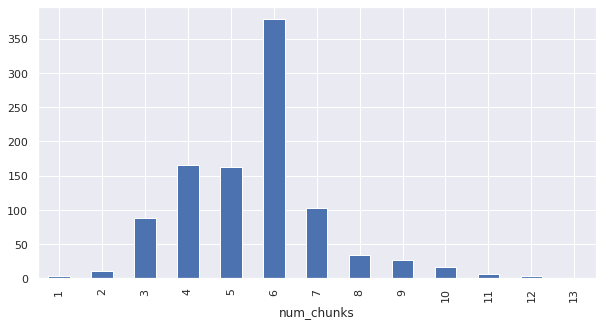

In [154]:
# plot the number of chunks for strong passwords
sns.set(rc={'figure.figsize':(10, 5)})
strong_pw_chunks.groupby(['num_chunks']).size().plot(kind = "bar")

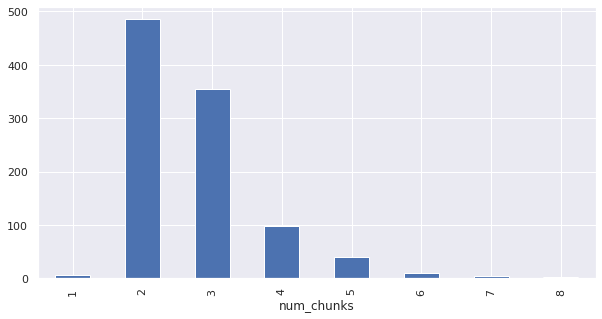

In [155]:
# plot the number of chunks for weak passwords
weak_pw_chunks.groupby(['num_chunks']).size().plot(kind = "bar")

In [143]:
strong_pw_chunks.to_csv('strong_pw_chunks_1000.csv', index = False)
weak_pw_chunks.to_csv('weak_pw_chunks_1000.csv', index = False)

## Others

In [ ]:
# add a new column (score): the similarity between username and its password
def generate_score(df):
  ps_user = pd.DataFrame()
  for row in df.itertuples():
    score = cal_similarity(row.username, row.pw)
    ps_user = ps_user.append({"username": row.username, "pw": row.pw, "service": row.service, "score": score}, ignore_index = True)
  return ps_user
ps_user = generate_score(ps_emails_new)

In [ ]:
# ps_user.head()

,username,pw,service,score
0,00-00-00-00,данияр123456789101112131415,VK,0.319388
1,10--camii--07,100797patitas25,Neopets,0.401715
2,20--w484-korchak_valja,rjhxfr321ledivivi,ExploitIn,0.456123
3,40-1-bol-teste-testando,"397,626,962,188,124",LinkedIn,0.251605
4,40-1-letra_b-teste-testando,"546,892,118,735,621",LinkedIn,0.257641


In [ ]:
# ps_user.sort_values(by='score', ascending=False)

,username,pw,service,score
23340,z6a79a_grjevzf,z6a79a_grjevzf,ExploitIn,1.000000
19398,h2omega-tania,h2omega-tania,ExploitIn,1.000000
17429,m16200301313_312_i,m16200301313_312_I,AntiPublic,1.000000
1474,q0vnugnw1scqs6i,q0vnugnw1scqs6i,ExploitIn,1.000000
4188,b0_tru0ng_cai_bang_xzlk,B0_tru0ng_cai_bang_xzlk,ExploitIn,1.000000
...,...,...,...,...
26195,iaqiodca,Я эгоистка 3000,VK,-0.003873
4861,3014highestave,bearsofchicago,AntiPublic,-0.006197
20296,k2-john,"248,764,373,937,439",ExploitIn,-0.020073
12094,k13jack,"1,466,238,524",AntiPublic,-0.025780


In [ ]:
# check how many usernames are the same as their passwords
# len(ps_user[ps_user['username'] == ps_user['pw']])

In [ ]:
# ps_user.to_csv('ps_user_score.csv', index = False)

In [ ]:
# select the top 10000 users whose usernames are the most similar to their passwords for experimentation
# ps_user_10000 = ps_user.sort_values(by='score', ascending=False)[:10000]

In [ ]:
# ps_user_10000.to_csv('ps_user_10000.csv', index = False)

In [ ]:
# ps_user_10000 = pd.read_csv('ps_user_10000.csv')

In [ ]:
# ps_user_1000 = ps_user_10000.sort_values(by='score', ascending=False)[:1000]

In [ ]:
# ps_user_1000.to_csv('ps_user_1000.csv', index = False)

## Tweaking

In [ ]:
# generate honeywords by tweaking
def chafffing_by_tweak(df):
    real_passwords = df['pw']
    print("start to generate honeywords_tweak.")
    symbols = ['!', '#', '$', '%', '&', '"', '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?',
               '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', "'"]
    f = 0.03
    p = 0.3
    q = 0.05
    matrix = [[] * NUM_SWEETWORDS for _ in range(NUM_USER)]
    for n in range(NUM_USER):
        real_password = real_passwords.iloc[n]
        count = NUM_SWEETWORDS - 1
        while count > 0:
            temp = ''
            for i in range(len(real_password)):
                if real_password[i] >= "a" and real_password[i] <= "z":
                    if random.random() <= p:
                        temp += real_password[i].upper()
                    else:
                        temp += real_password[i]
                elif real_password[i] >= "A" and real_password[i] <= "Z":
                    if random.random() <= q:
                        temp += real_password[i].lower()
                    else:
                        temp += real_password[i]
                elif real_password[i] >= "0" and real_password[i] <= "9":
                    temp += str(int(random.random() * 10))
                elif real_password[i] in symbols:
                    temp += symbols[int(random.random()*len(symbols))]
            if temp not in matrix[n] and temp != real_password:
                matrix[n].append(temp)
                count -= 1
    combined_matrix = np.c_[real_passwords, matrix]
    pd.DataFrame(combined_matrix).to_csv('honeywords_tweaking_1000.csv', index = False)
    # write the 2d matrix to a text file
    return combined_matrix

In [ ]:
honeywords_tweaking = chafffing_by_tweak(real_passwords)

start to generate honeywords_tweak.


In [ ]:
len(honeywords_tweaking)

1000

In [ ]:
honeywords_tweaking

## Evaluate

In [ ]:
def cal_scores(arr):
  scores = [[0 for x in range(NUM_SWEETWORDS)] for y in range(NUM_USER)] 
  for i in range(NUM_USER):
    for j in range(NUM_SWEETWORDS):
      honeyword = arr[i][j]
      score = cal_similarity(arr[i][0], arr[i][j])
      scores[i][j] = score
  return scores

In [ ]:
NUM_USER = 1000
scores = cal_scores(honeywords_tweaking)

In [ ]:
tweaking_scores  = pd.read_csv("data/similarity_scores/tweaking_scores_1000.csv", header = None)

In [ ]:
avg_scores = avg_scores(tweaking_scores )
avg_scores

In [ ]:
np.savetxt("tweaking_avg_scores_1000.csv", avg_scores, delimiter =", ", fmt ='% s')

In [ ]:
print("The average similarity score of honeywords bu tweaking is:", sum(avg_scores)/len(avg_scores))

The average similarity score of honeywords bu tweaking is: 0.7832473251490198


## FastText

In [ ]:
# generate honeywords by FastText
def chaffing_by_fasttext(df):
    real_passwords = df['pw']
    print("start to generate honeywords_fasttext.")
    model = fasttext.load_model("model_trained_on_rockyou_500_epochs.bin")
    honeywords=[]
    for real_password in real_passwords:
        honeywords.append(real_password)
        temp = model.get_nearest_neighbors(real_password,k=NUM_SWEETWORDS-1)
        for element in temp:
            honeywords.append(element[1])

    matrix = np.array(honeywords).reshape(-1, NUM_SWEETWORDS)
    pd.DataFrame(matrix).to_csv('honeywords_fasttext_1000.csv', index = False)
    print("honeywords_fasttext generated.")
    return matrix

In [ ]:
honeywords_fasttext = chaffing_by_fasttext(real_passwords)

start to generate honeywords_fasttext.


In [ ]:
len(honeywords_fasttext)

1000

In [ ]:
honeywords_fasttext

array([['z6a79a_grjevzf', 'evedsoid', 'xaaphute', ..., 'exb3p_li',
        'gatszaxb', 'Mu__lAx5'],
       ['u111511111111', 'manandber', '08151005', ..., '050212313',
        'chan2008', 'mania205'],
       ['h2omega-tania', 'karert_334', 'lannthpx', ..., 'dizklyna1',
        'hambong28', 'hsslidag21'],
       ...,
       ['fjrw5854sjk4mqg', 'pebob1e0o', 'takakyl', ..., 'jjmiodk',
        'sutcaheve', '_rrk_iskako'],
       ['j38dfj27@example.com', '1dtiplune', 'tyetikime', ..., '2ssthza',
        'lpordeve', '3fEcbl6'],
       ['alinka80977249704', '7893704401', '512478', ..., 'kilay20',
        'jancik91', '26847796']], dtype='<U34')

In [ ]:
fasttext_scores = cal_scores(honeywords_fasttext)

In [ ]:
display(fasttext_scores[0][1:])
np.savetxt("fasttext_scores_1000.csv", fasttext_scores, delimiter =", ", fmt ='% s')

[0.3430747985839844,
 0.35578376054763794,
 0.27168604731559753,
 0.4438930153846741,
 0.4328509569168091,
 0.6133686304092407,
 0.47587788105010986,
 0.2854139804840088,
 0.406730055809021,
 0.33069223165512085,
 0.5110376477241516,
 0.33590370416641235,
 0.4267650544643402,
 0.5442410707473755,
 0.5880048871040344,
 0.43491894006729126,
 0.4361203908920288,
 0.4211512804031372,
 0.34352415800094604]

In [ ]:
fasttext_scores  = pd.read_csv("data/similarity_scores/fasttext_scores_1000.csv", header = None)

In [ ]:
fasttext_scores.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.0,0.343075,0.355784,0.271686,0.443893,0.432851,0.613369,0.475878,0.285414,0.406730,0.330692,0.511038,0.335904,0.426765,0.544241,0.588005,0.434919,0.436120,0.421151,0.343524
1,1.0,0.217880,0.494094,0.261260,0.418987,0.292383,0.391614,0.304608,0.426736,0.366661,0.490206,0.378754,0.475126,0.363322,0.577306,0.450816,0.525793,0.398193,0.228311,0.228611
2,1.0,0.358228,0.422626,0.333588,0.295029,0.224880,0.255364,0.359947,0.406017,0.459222,0.281882,0.560930,0.164349,0.309300,0.389872,0.345799,0.273811,0.410179,0.301957,0.364207
3,1.0,0.521001,0.400412,0.498266,0.360897,0.440559,0.337167,0.482135,0.272490,0.360320,0.392633,0.334296,0.275087,0.459075,0.513840,0.516891,0.429384,0.310131,0.549566,0.631949
4,1.0,0.309676,0.443596,0.204545,0.313823,0.301961,0.297178,0.414019,0.404729,0.416569,0.358284,0.299638,0.457617,0.544448,0.489354,0.328972,0.374649,0.355185,0.333629,0.168076


In [ ]:
fasttext_avg_scores = avg_scores(fasttext_scores)

In [ ]:
np.savetxt("fasttext_avg_scores_1000.csv", fasttext_avg_scores , delimiter =", ", fmt ='% s')

In [ ]:
print("The average similarity score of honeywords by fasttext is:", sum(fasttext_avg_scores)/len(fasttext_avg_scores))

The average similarity score of honeywords by fasttext is: 0.38182773044337814


## GPT-3

In [ ]:
def GPT3_honeywords(df):
  real_password = df['pw']
  response = openai.Completion.create(
    model="text-davinci-002",
    prompt="Derive 19 passwords that are similar to " + real_password + ". The length of the passwords should be more than 12.",
    temperature=1,
    max_tokens=256,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0
  )
  result = response.choices[0].text.strip().split()
  return result

In [ ]:
display(real_passwords[2])
samples = GPT3_honeywords(real_passwords[2])

'm16200301313_312_I'

In [ ]:
samples 

In [ ]:
def chaffing_by_GPT3(real_passwords):
  sweetwords = {}
  for real_password in real_passwords:
    sweetwords[real_password] = GPT3_honeywords(real_password)
  return sweetwords

In [ ]:
sweetwords_GPT = chaffing_by_GPT3(real_passwords)

In [ ]:
res = []
for key, val in sweetwords_GPT.items():
  res.append([key] + val)

In [ ]:
len(res)

1000

In [ ]:
honeywords_GPT3 = res
pd.DataFrame(honeywords_GPT3).to_csv('honeywords_GPT3_1000.csv', index = False)

In [ ]:
ls

'ACSAC reviews.gdoc'       model_trained_on_rockyou_500_epochs.bin
 data/                     MPNet_Cosine_similarity.ipynb
'HGT comparison.gslides'   paper/
 honeywords_fasttext.txt  'User study'/


In [ ]:
honeywords_GPT3  = pd.read_csv("data/honeywords/honeywords_GPT3_1000.csv")

In [ ]:
honeywords_GPT3_new = pd.DataFrame(index=honeywords_GPT3.index, columns=honeywords_GPT3.columns)

In [ ]:
# delete values with length less than 8
for i in range(len(honeywords_GPT3)):
  for j in range(72):
    if len(str(honeywords_GPT3.iloc[i][j]))>8:
      honeywords_GPT3_new.iloc[i][j] = honeywords_GPT3.iloc[i][j]

In [ ]:
honeywords_GPT3_new.iloc[3][0] != 'nan'

True

In [ ]:
honeywords_GPT3_new.to_csv('honeywords_GPT3_1000_8plus.', index = False)

In [ ]:
honeywords_GPT3_new.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,z6a79a_grjevzf,NaN,d7b8ab_gtkfwag,NaN,f9d2cd_jvpkcbi,NaN,g3e6ef_kxqlgdj,NaN,h5f0g1_lzsnhfk,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,u111511111111,1111111111111111,11111111111111111,111111111111111111,1111111111111111111,11111111111111111111,111111111111111111111,1111111111111111111111,11111111111111111111111,111111111111111111111111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,h2omega-tania,H2omega-tania12,H2omega-tania123,H2omega-tania1234,H2omega-tania12345,H2omega-tania123456,H2omega-tania1234567,H2omega-tania12345678,H2omega-tania123456789,H2omega-tania1234567890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,o0o4nh_ch4ng_s4u_Mu0no0o,o0o4nh_ch4ng_s4u_Mu0,o0o4nh_ch4ng_s4u_Mu0no0,o0o4nh_ch4ng_s4u_Mu0no0o,o0o4nh_ch4ng_s4u_Mu0no0o1,o0o4nh_ch4ng_s4u_Mu0no0o2,o0o4nh_ch4ng_s4u_Mu0no0o3,o0o4nh_ch4ng_s4u_Mu0no0o4,o0o4nh_ch4ng_s4u_Mu0no0o5,o0o4nh_ch4ng_s4u_Mu0no0o6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,o0o_Zay_Chou_o0o,o0oZayChouo0o,0123456789_,o0o_Zay_Chou_o0o,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def cal_scores2(df):
  scores = [0 for x in range(NUM_USER)] 
  for i in range(NUM_USER):
    temp = 0
    count = 0
    for j in range(1, NUM_SWEETWORDS):
      honeyword = str(df.iloc[i][j]) 
      real_password = str(df.iloc[i][0])
      if honeyword != 'nan'and honeyword != real_password:
        score = cal_similarity(real_password, str(df.iloc[i][j]))
        count += 1
        temp = temp + score
    if count != 0:
      scores[i] = temp/count
    else:
      scores[i] = 1
  return scores

In [ ]:
GPT3_avg_scores = cal_scores2(honeywords_GPT3_new)

In [ ]:
np.savetxt("GPT3_scores_1000.csv", GPT3_avg_scores, delimiter =", ", fmt ='% s')

In [ ]:
print("The average similarity score of honeywords by GPT3 is:", sum(GPT3_avg_scores)/len(GPT3_avg_scores))

The average similarity score of honeywords by GPT3 is: 0.8970959020857113
